## A transdimensional piecewise constant regression
Bla bla **super important** 

$$ 
\alpha = \frac{1}{\exp ^2}
$$


In [1]:
import statistics
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import math
from random import random
from scipy.optimize import curve_fit

In [2]:
class Model:
    """Store model unknowns (Voronoï nuclei number and coordinates)
    Attributes:
        x (float list): x coordinate of each nucleus
        y (float list): y coordinate of each nucleus
        npa (int): number of partitions
        npa_min (int): minimal possible number of partitions
        npa_max (int): maximal possible number of partitions
        phi (float): misfit function which quantifies the agreement between simulated and observed data
        birth_param (tuple): store nucleus birth parameterization
        death_param (tuple): store nucleus death parameterization
        curr_perturbation (str): state of the perturbation at current iteration
    """

    def __init__(self):
        """Model class constructor
        """
        self.x = []
        self.y = []
        self.npa_min = int
        self.npa_max = int
        self.npa = int
        self.phi = float
        self.birth_param = tuple
        self.death_param = tuple
        self.curr_perturbation = str

    def build_initial_model(self, x_min, x_max, y_dobs):
        self.npa_min = 1  # min number of partitions
        self.npa_max = 50  # max number of partitions
        self.npa = np.random.randint(self.npa_min, self.npa_max + 1)  # number of partitions
        for i in range(self.npa):
            self.x.append(np.random.uniform(x_min, x_max))  # x distribution
            self.y.append(np.random.uniform(min(y_dobs), max(y_dobs)))  # y distribution

    def build_proposed_model(self, current_model_):
        self.npa = current_model_.npa  # number of partitions
        perturb_type = random()  # random number to choice the perturbation type to apply (birth, death, and move)
        if perturb_type < 0.33:
            self.move(current_model_)
            self.curr_perturbation = "move"
        elif 0.33 <= perturb_type <= 0.66:
            self.birth(current_model_)
            self.curr_perturbation = "birth"
        else:
            self.death(current_model_)
            self.curr_perturbation = "death"

    def move(self, current_model_):
        move_type = random()  # random number to choice the move perturbation to apply
        if move_type < 0.33:  # move all nuclei
            for k in range(self.npa):
                self.x.append(np.random.normal(current_model_.x[k], 0.7))  # x gaussian perturbation
                self.y.append(np.random.normal(current_model_.y[k], 8))  # y gaussian perturbation
        elif 0.33 <= move_type <= 0.66:  # move one nucleus in x & y axes
            for k in range(self.npa):
                self.x.append(current_model_.x[k])
                self.y.append(current_model_.y[k])
            move_index = self.x.index(np.random.choice(self.x))  # index of the random point to move
            self.x[move_index] = np.random.normal(self.x[move_index], 2)  # x gaussian perturbation
            self.y[move_index] = np.random.normal(self.y[move_index], 20)  # y gaussian perturbation
        else:  # move one nucleus in x-axis
            for k in range(self.npa):
                self.x.append(current_model_.x[k])
                self.y.append(current_model_.y[k])
            move_index = self.x.index(np.random.choice(self.x))  # index of the random point to move
            self.x[move_index] = np.random.normal(self.x[move_index], 4)  # x gaussian perturbation

    def fullrand_birth(self, current_model_):
        self.npa += 1  # increasing number of partitions
        for k in range(self.npa - 1):
            self.x.append(current_model_.x[k])
            self.y.append(current_model_.y[k])
        self.x.append(np.random.uniform(x_min, x_max))  # x prior distribution
        self.y.append(np.random.uniform(min(y_dobs), max(y_dobs)))  # y prior distribution

    def fullrand_death(self, current_model_):
        if self.npa > 1:
            self.npa -= 1  # decreasing number of partitions
            for k in range(self.npa + 1):
                self.x.append(current_model_.x[k])
                self.y.append(current_model_.y[k])
            death_index = self.x.index(np.random.choice(self.x))  # index of the random point to delete
            del self.x[death_index]
            del self.y[death_index]
        else:
            for k in range(self.npa):
                self.x.append(current_model_.x[k])
                self.y.append(current_model_.y[k])

    def birth(self, current_model_):
        self.npa += 1  # increasing number of partitions
        sigma2 = 2
        for k in range(self.npa - 1):
            self.x.append(current_model_.x[k])
            self.y.append(current_model_.y[k])
        self.x.append(np.random.uniform(x_min, x_max))  # x prior distribution
        distance = []
        for nucleus in range(self.npa - 1):
            # print(range(self.npa))
            # print('nucleus', nucleus)
            # print('npa nucleus', self.x[nucleus])
            distance.append(abs(self.x[self.npa - 1] - self.x[nucleus]))
        index_min_dist = distance.index(min(distance))  # index of distance with the closest model point
        # print('index min distance', index_min_dist)
        self.y.append(np.random.normal(self.y[index_min_dist], sigma2))
        vi = self.y[index_min_dist]
        vnp1 = self.y[self.npa - 1]
        self.birth_param = (vnp1, vi)

    def death(self, current_model_):
        if self.npa > 1:
            self.npa -= 1  # decreasing number of partitions
            for k in range(self.npa + 1):
                self.x.append(current_model_.x[k])
                self.y.append(current_model_.y[k])
            death_index = self.x.index(np.random.choice(self.x))  # index of the random point to delete
            point_to_kill = self.x[death_index]  # value of the nucleus to be killed
            del self.x[death_index]
            distance = []
            for nucleus in range(self.npa):
                distance.append(abs(point_to_kill - self.x[nucleus]))
            index_min_dist = distance.index(min(distance))  # index of distance with the closest model point
            vi = self.y[death_index]
            vj = self.y[index_min_dist]
            self.death_param = (vj, vi)
            del self.y[death_index]
        else:
            print('npa = ', self.npa, 'so nothing is done')
            for k in range(self.npa):
                self.x.append(current_model_.x[k])
                self.y.append(current_model_.y[k])
    def compute_likelihood(self):
        return math.exp(-(1 / 2) * self.phi)

    def compute_phi(self, x_dobs, y_dobs):
        self.phi = 0
        for j in range(len(x_dobs)):
            distance = []
            for nucleus in range(len(self.x)):
                distance.append(abs(x_dobs[j] - self.x[nucleus]))
                # print('distance', distance)
            index_min_dist = distance.index(min(distance))  # index of distance with the closest model point
            # print('distance min index', index_min_dist)
            self.phi += pow(y_dobs[j] - self.y[index_min_dist], 2) / pow(sigma, 2)

In [3]:
def compute_acceptance(current_model_, proposed_model_):
    # Compute prior of the proposed model (i.e. check if npa, x and y within bounds)
    prior = 1
    if proposed_model_.npa < initial_model.npa_min or proposed_model_.npa > initial_model.npa_max:
        prior = 0
    else:
        for i in range(len(proposed_model_.x)):
            if proposed_model_.x[i] > x_max or proposed_model_.x[i] < x_min or \
                    proposed_model_.y[i] > max(y_dobs) or proposed_model_.y[i] < min(y_dobs):
                prior = 0
    # print("prior", prior)

    sigma2 = 2  # standard deviation from Gaussian probability density
    delta_v = max(y_dobs) - min(y_dobs)  # uniform y distribution
    if proposed_model_.curr_perturbation == "move":
        # Compute likelihood of the proposed model
        proposed_likelihood = proposed_model_.compute_likelihood()
        current_likelihood = current_model_.compute_likelihood()
        # print('proposed likelihood', proposed_likelihood)
        return prior * (proposed_likelihood / current_likelihood)  # acceptance term
    elif proposed_model_.curr_perturbation == "birth":
        vnp1 = proposed_model_.birth_param[0]
        vi = proposed_model_.birth_param[1]
        return prior * (sigma2 * math.sqrt(2 * math.pi) / delta_v) * math.exp(
            (pow(vnp1 - vi, 2) / (2 * pow(sigma2, 2))) - ((proposed_model_.phi - current_model_.phi) / 2))
    elif proposed_model_.curr_perturbation == "death":
        vj = proposed_model_.death_param[0]
        vi = proposed_model_.death_param[1]
        return prior * delta_v / (sigma2 * math.sqrt(2 * math.pi)) * math.exp(
            -(pow(vj - vi, 2) / (2 * pow(sigma2, 2))) - (
                    (proposed_model_.phi - current_model_.phi) / 2))
    else:
        proposed_likelihood = proposed_model_.compute_likelihood()
        current_likelihood = current_model_.compute_likelihood()
        return prior * (proposed_likelihood / current_likelihood)  # acceptance term


def draw_fit_curve(initial_model_, mean_x, mean_y):
    xFit = np.arange(min(mean_x), max(mean_x), 0.01)
    if initial_model_.npa >= 10:
        popt, _ = curve_fit(fifth_polynomial_regression, mean_x, mean_y)
        a, b, c, d, e, f = popt
        plt.plot(xFit, fifth_polynomial_regression(xFit, *popt), 'purple')
    elif 3 < initial_model_.npa < 10:
        popt, _ = curve_fit(second_polynomial_regression, mean_x, mean_y)
        a, b, c = popt
        plt.plot(xFit, second_polynomial_regression(xFit, *popt), 'purple')
    elif 1 < initial_model_.npa < 4:
        popt, _ = curve_fit(linear_regression, mean_x, mean_y)
        a, b = popt
        plt.plot(xFit, linear_regression(xFit, *popt), 'purple')


# define the true objective function
def fifth_polynomial_regression(x, a, b, c, d, e, f):
    return (a * x) + (b * x ** 2) + (c * x ** 3) + (d * x ** 4) + (e * x ** 5) + f


def second_polynomial_regression(x, a, b, c):
    return a * x + b * x ** 2 + c


def linear_regression(x, a, b):
    return a * x + b

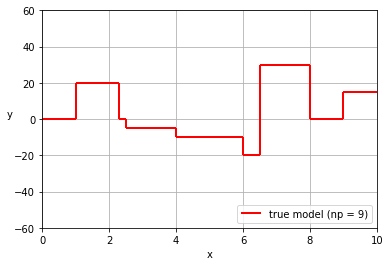

In [4]:
fig, ax = plt.subplots()

# Plot true model
h1 = ax.hlines(y=0, xmin=0, xmax=1, linewidth=2, color='r', label='true model (np = 9)')
v1 = ax.vlines(x=1, ymin=0, ymax=20, linewidth=2, color='r')
h2 = ax.hlines(y=20, xmin=1, xmax=2.3, linewidth=2, color='r')
v2 = ax.vlines(x=2.3, ymin=0, ymax=20, linewidth=2, color='r')
h3 = ax.hlines(y=0, xmin=2.3, xmax=2.5, linewidth=2, color='r')
v3 = ax.vlines(x=2.5, ymin=-5, ymax=0, linewidth=2, color='r')
h4 = ax.hlines(y=-5, xmin=2.5, xmax=4, linewidth=2, color='r')
v4 = ax.vlines(x=4, ymin=-10, ymax=-5, linewidth=2, color='r')
h5 = ax.hlines(y=-10, xmin=4, xmax=6, linewidth=2, color='r')
v5 = ax.vlines(x=6, ymin=-20, ymax=-10, linewidth=2, color='r')
h6 = ax.hlines(y=-20, xmin=6, xmax=6.5, linewidth=2, color='r')
v6 = ax.vlines(x=6.5, ymin=-20, ymax=30, linewidth=2, color='r')
h7 = ax.hlines(y=30, xmin=6.5, xmax=8, linewidth=2, color='r')
v7 = ax.vlines(x=8, ymin=0, ymax=30, linewidth=2, color='r')
h8 = ax.hlines(y=0, xmin=8, xmax=9, linewidth=2, color='r')
v8 = ax.vlines(x=9, ymin=0, ymax=15, linewidth=2, color='r')
h9 = ax.hlines(y=15, xmin=9, xmax=10, linewidth=2, color='r')

x_dobs = []  # x coordinates of observed data
y_dobs = []  # y coordinates of observed data
sum_x = 0.0
step = 0.1  # observed data sampling on x
prev_i = 0
true_x = np.array([10, 23, 25, 40, 60, 65, 80, 90, 100])
true_y = np.array([0, 20, 0, -5, -10, -20, 30, 0, 15])
sigma = 10  # standard deviation
x_min = 0
x_max = 10
y_min = -60
y_max = 60

plt.xlim([x_min, x_max])
plt.ylim([y_min, y_max])
plt.xlabel('x')
plt.ylabel('y', rotation=0)
plt.legend(loc='lower right')
plt.grid()

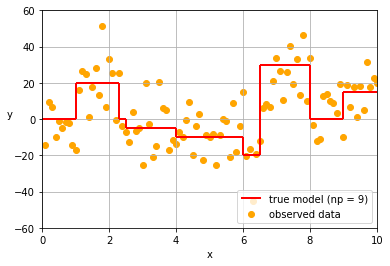

In [5]:
# Noisy points (observed data) creation
for i in range(len(true_x)):
    for j in range(prev_i, true_x[i]):
        sum_x += step
        x_dobs.append(sum_x)
        s = np.random.normal(true_y[i], sigma)  # add gaussian noise on points
        y_dobs.append(s)
    prev_i = true_x[i]

fig, ax = plt.subplots()

h1 = ax.hlines(y=0, xmin=0, xmax=1, linewidth=2, color='r', label='true model (np = 9)')
v1 = ax.vlines(x=1, ymin=0, ymax=20, linewidth=2, color='r')
h2 = ax.hlines(y=20, xmin=1, xmax=2.3, linewidth=2, color='r')
v2 = ax.vlines(x=2.3, ymin=0, ymax=20, linewidth=2, color='r')
h3 = ax.hlines(y=0, xmin=2.3, xmax=2.5, linewidth=2, color='r')
v3 = ax.vlines(x=2.5, ymin=-5, ymax=0, linewidth=2, color='r')
h4 = ax.hlines(y=-5, xmin=2.5, xmax=4, linewidth=2, color='r')
v4 = ax.vlines(x=4, ymin=-10, ymax=-5, linewidth=2, color='r')
h5 = ax.hlines(y=-10, xmin=4, xmax=6, linewidth=2, color='r')
v5 = ax.vlines(x=6, ymin=-20, ymax=-10, linewidth=2, color='r')
h6 = ax.hlines(y=-20, xmin=6, xmax=6.5, linewidth=2, color='r')
v6 = ax.vlines(x=6.5, ymin=-20, ymax=30, linewidth=2, color='r')
h7 = ax.hlines(y=30, xmin=6.5, xmax=8, linewidth=2, color='r')
v7 = ax.vlines(x=8, ymin=0, ymax=30, linewidth=2, color='r')
h8 = ax.hlines(y=0, xmin=8, xmax=9, linewidth=2, color='r')
v8 = ax.vlines(x=9, ymin=0, ymax=15, linewidth=2, color='r')
h9 = ax.hlines(y=15, xmin=9, xmax=10, linewidth=2, color='r')
plt.scatter(x_dobs, y_dobs, c='orange', label='observed data')
plt.xlim([x_min, x_max])
plt.ylim([y_min, y_max])
plt.xlabel('x')
plt.ylabel('y', rotation=0)
plt.legend(loc='lower right')
plt.grid()
plt.show()

[1.4972951827196357, 5.004190364845259, 0.17169270100910294, 8.727918593181094, 3.0820464126936518, 1.7456114763511055, 9.596108278056034, 0.07555443396246031, 9.215121476199958, 3.8872697537976064, 1.4737801836711084, 2.3590319713548444, 1.3698244351268474, 5.142321661994749, 5.751957050563467, 4.165505202744147, 3.026867901175836, 1.2972577552515807, 1.0910984080113917, 5.898730193991744, 7.044888415247671, 5.241102308727551, 1.8545495240511611, 4.323902823236303, 1.3931421554987633, 3.9414685791918815, 0.6761695659997791, 4.497850737710138, 0.8279247893605091] [30.308743099136258, 13.826178224672155, -22.9391647700379, 43.24622921841375, -31.349975423742855, 25.123341459514116, 32.04771822375803, -22.014550547305905, 26.93932417008846, 7.629489898949473, -41.81458092082556, 47.781403070214274, 38.29561400791183, -14.952889882471904, -41.41966315436211, -13.251920460248513, -16.8902479197716, 19.794514792954196, 9.54197717624325, -37.856068468082306, -41.48411671450762, -27.696210955

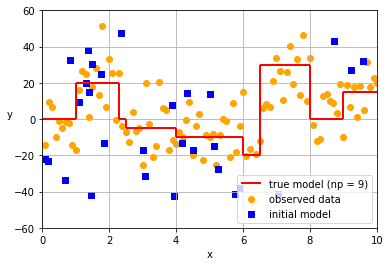

In [6]:
######### RJMCMC implementation ###########
# Build initial model
initial_model = Model()
initial_model.build_initial_model(x_min, x_max, y_dobs)
print(initial_model.x, initial_model.y, initial_model.npa)

# Compute phi of the initial model
initial_model.compute_phi(x_dobs, y_dobs)
# print('first likelihood', current_likelihood)

fig, ax = plt.subplots()

h1 = ax.hlines(y=0, xmin=0, xmax=1, linewidth=2, color='r', label='true model (np = 9)')
v1 = ax.vlines(x=1, ymin=0, ymax=20, linewidth=2, color='r')
h2 = ax.hlines(y=20, xmin=1, xmax=2.3, linewidth=2, color='r')
v2 = ax.vlines(x=2.3, ymin=0, ymax=20, linewidth=2, color='r')
h3 = ax.hlines(y=0, xmin=2.3, xmax=2.5, linewidth=2, color='r')
v3 = ax.vlines(x=2.5, ymin=-5, ymax=0, linewidth=2, color='r')
h4 = ax.hlines(y=-5, xmin=2.5, xmax=4, linewidth=2, color='r')
v4 = ax.vlines(x=4, ymin=-10, ymax=-5, linewidth=2, color='r')
h5 = ax.hlines(y=-10, xmin=4, xmax=6, linewidth=2, color='r')
v5 = ax.vlines(x=6, ymin=-20, ymax=-10, linewidth=2, color='r')
h6 = ax.hlines(y=-20, xmin=6, xmax=6.5, linewidth=2, color='r')
v6 = ax.vlines(x=6.5, ymin=-20, ymax=30, linewidth=2, color='r')
h7 = ax.hlines(y=30, xmin=6.5, xmax=8, linewidth=2, color='r')
v7 = ax.vlines(x=8, ymin=0, ymax=30, linewidth=2, color='r')
h8 = ax.hlines(y=0, xmin=8, xmax=9, linewidth=2, color='r')
v8 = ax.vlines(x=9, ymin=0, ymax=15, linewidth=2, color='r')
h9 = ax.hlines(y=15, xmin=9, xmax=10, linewidth=2, color='r')
plt.scatter(x_dobs, y_dobs, c='orange', label='observed data')
plt.scatter(initial_model.x, initial_model.y, c='blue', marker='s', label='initial model')
plt.xlim([x_min, x_max])
plt.ylim([y_min, y_max])
plt.xlabel('x')
plt.ylabel('y', rotation=0)
plt.legend(loc='lower right')
plt.grid()

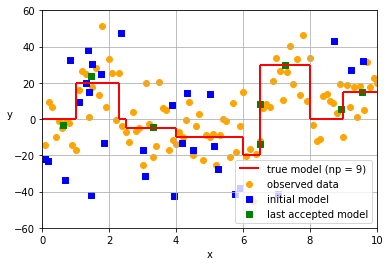

In [7]:
# Set RJMCMC variables
current_model = initial_model
burn_in = 10000  # length of the burn-in period
nsamples = 50000  # total number of samples
accepted_models = 0  # number of accepted models
rejected_models = 0  # number of rejected models
model_space = []  # model space we want to sample

for sample in range(nsamples):
    u = random()
    # print('u', u)
    # Build proposed model with a perturbation from current model
    proposed_model = Model()
    proposed_model.build_proposed_model(current_model)

    # Compute phi of the proposed model
    proposed_model.compute_phi(x_dobs, y_dobs)

    # Compute prior of the proposed model (i.e. check if npa, x and y within bounds)
    """prior = 1
    if proposed_model.npa < initial_model.npa_min or proposed_model.npa > initial_model.npa_max:
        prior = 0
    else:
        for i in range(len(proposed_model.x)):
            if proposed_model.x[i] > x_max or proposed_model.x[i] < x_min or \
                    proposed_model.y[i] > max(y_dobs) or proposed_model.y[i] < min(y_dobs):
                prior = 0
    # print("prior", prior)"""

    alpha = compute_acceptance(current_model, proposed_model)
    # print('alpha', alpha)
    if alpha > 1:
        alpha = 1
    if alpha >= u:  # if accepted
        current_model = proposed_model
        accepted_models += 1
    else:  # if rejected
        rejected_models += 1

    # Collect models in the chain if burn-in period has passed
    if sample >= burn_in:
        model_space.append(current_model)
        
fig, ax = plt.subplots()

h1 = ax.hlines(y=0, xmin=0, xmax=1, linewidth=2, color='r', label='true model (np = 9)')
v1 = ax.vlines(x=1, ymin=0, ymax=20, linewidth=2, color='r')
h2 = ax.hlines(y=20, xmin=1, xmax=2.3, linewidth=2, color='r')
v2 = ax.vlines(x=2.3, ymin=0, ymax=20, linewidth=2, color='r')
h3 = ax.hlines(y=0, xmin=2.3, xmax=2.5, linewidth=2, color='r')
v3 = ax.vlines(x=2.5, ymin=-5, ymax=0, linewidth=2, color='r')
h4 = ax.hlines(y=-5, xmin=2.5, xmax=4, linewidth=2, color='r')
v4 = ax.vlines(x=4, ymin=-10, ymax=-5, linewidth=2, color='r')
h5 = ax.hlines(y=-10, xmin=4, xmax=6, linewidth=2, color='r')
v5 = ax.vlines(x=6, ymin=-20, ymax=-10, linewidth=2, color='r')
h6 = ax.hlines(y=-20, xmin=6, xmax=6.5, linewidth=2, color='r')
v6 = ax.vlines(x=6.5, ymin=-20, ymax=30, linewidth=2, color='r')
h7 = ax.hlines(y=30, xmin=6.5, xmax=8, linewidth=2, color='r')
v7 = ax.vlines(x=8, ymin=0, ymax=30, linewidth=2, color='r')
h8 = ax.hlines(y=0, xmin=8, xmax=9, linewidth=2, color='r')
v8 = ax.vlines(x=9, ymin=0, ymax=15, linewidth=2, color='r')
h9 = ax.hlines(y=15, xmin=9, xmax=10, linewidth=2, color='r')
plt.scatter(x_dobs, y_dobs, c='orange', label='observed data')
plt.scatter(initial_model.x, initial_model.y, c='blue', marker='s', label='initial model')
plt.scatter(current_model.x, current_model.y, c='green', marker='s', label='last accepted model')
plt.xlim([x_min, x_max])
plt.ylim([y_min, y_max])
plt.xlabel('x')
plt.ylabel('y', rotation=0)
plt.legend(loc='lower right')
plt.grid()

accepted models 2942
rejected models 47058
acceptance rate 5.884
mean 10.07385
std 2.468551907741263


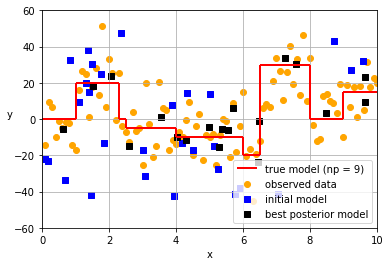

In [8]:
print("accepted models", accepted_models)
print("rejected models", rejected_models)
acceptance_rate = 100 * accepted_models / nsamples
print("acceptance rate", acceptance_rate)

# Compute model number of partitions and take max likelihood model
npa_number = []
model_likelihood = []
model_posterior = []
gaussian_formula = 1.0 / pow(2.0 * math.pi * sigma, len(x_dobs) / 2)  # likelihood model equation first term
for model in model_space:
    npa_number.append(model.npa)
    model.compute_phi(x_dobs, y_dobs)
    prior = 1 / (max(model.y) - min(model.y))
    model_likelihood.append(gaussian_formula * model.compute_likelihood())
    model_posterior.append(prior * (gaussian_formula * model.compute_likelihood()))
max_likelihood_model = model_likelihood.index(max(model_likelihood))
max_posterior_model = model_posterior.index(max(model_posterior))

# print("npa list", npa_number)
print('mean', statistics.mean(npa_number))
print('std', statistics.stdev(npa_number))


fig, ax = plt.subplots()

h1 = ax.hlines(y=0, xmin=0, xmax=1, linewidth=2, color='r', label='true model (np = 9)')
v1 = ax.vlines(x=1, ymin=0, ymax=20, linewidth=2, color='r')
h2 = ax.hlines(y=20, xmin=1, xmax=2.3, linewidth=2, color='r')
v2 = ax.vlines(x=2.3, ymin=0, ymax=20, linewidth=2, color='r')
h3 = ax.hlines(y=0, xmin=2.3, xmax=2.5, linewidth=2, color='r')
v3 = ax.vlines(x=2.5, ymin=-5, ymax=0, linewidth=2, color='r')
h4 = ax.hlines(y=-5, xmin=2.5, xmax=4, linewidth=2, color='r')
v4 = ax.vlines(x=4, ymin=-10, ymax=-5, linewidth=2, color='r')
h5 = ax.hlines(y=-10, xmin=4, xmax=6, linewidth=2, color='r')
v5 = ax.vlines(x=6, ymin=-20, ymax=-10, linewidth=2, color='r')
h6 = ax.hlines(y=-20, xmin=6, xmax=6.5, linewidth=2, color='r')
v6 = ax.vlines(x=6.5, ymin=-20, ymax=30, linewidth=2, color='r')
h7 = ax.hlines(y=30, xmin=6.5, xmax=8, linewidth=2, color='r')
v7 = ax.vlines(x=8, ymin=0, ymax=30, linewidth=2, color='r')
h8 = ax.hlines(y=0, xmin=8, xmax=9, linewidth=2, color='r')
v8 = ax.vlines(x=9, ymin=0, ymax=15, linewidth=2, color='r')
h9 = ax.hlines(y=15, xmin=9, xmax=10, linewidth=2, color='r')
plt.scatter(x_dobs, y_dobs, c='orange', label='observed data')
plt.scatter(initial_model.x, initial_model.y, c='blue', marker='s', label='initial model')
plt.scatter(model_space[max_posterior_model].x, model_space[max_posterior_model].y, c='black', marker='s', label='best posterior model')
plt.xlim([x_min, x_max])
plt.ylim([y_min, y_max])
plt.xlabel('x')
plt.ylabel('y', rotation=0)
plt.legend(loc='lower right')
plt.grid()

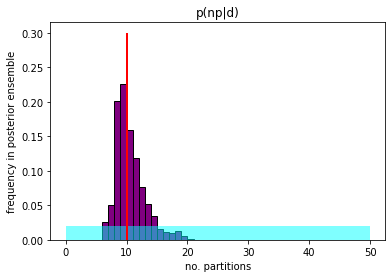

In [9]:
# Histograms of dimension prior and posterior probability
plot2 = plt.figure(2)
plt.hist(npa_number, range=(initial_model.npa_min, initial_model.npa_max), bins=(initial_model.npa_max-initial_model.npa_min), density=True, color='purple', edgecolor='black')
plt.hist(initial_model.npa_max, range=(0, initial_model.npa_max), bins=1, alpha=0.5, density=True, color='cyan')
v1 = plt.vlines(x=10, ymin=0, ymax=0.3, linewidth=2, color='r')
plt.xlabel('no. partitions')
plt.ylabel('frequency in posterior ensemble')
plt.title('p(np|d)')
plt.show()